# AWS Summit San Francisco 2022
## Using AWS Inferentia to optimize HuggingFace model inference

Welcome to the AWS Summit San Francisco 2022 Inferentia Workshop! 


# Table of contents
1. [Introduction](#introduction)
2. [Setting up the environment](#setenv)
3. [Get model from HuggingFace Model Hub](#getmodel)
    1. [Get the Tokenizer](#gettoken)
    2. [Create a trace for Sagemaker Neo compiler](#trace)
4. [Deploy default model to a CPU-based endpoint](#deploycpu)
    1. [Perform a test CPU based inference](#testcpu)
5. [Compile and deploy the model on an Inferentia instance](#compiledeploy)
    1. [Review changes to the inference code](#reviewchanges)
    2. [Create and compile Pytorch model for the inf1 instance](#pytorchmodel)
    3. [Deploy compiled model into the inf1 instance](#deployinf1)
    4. [Perform a test inf1 based inference](#testinf1)
6. [Benchmark and comparison](#benchmark)
    1. [Benchmark CPU based endpoint](#benchcpu)
    2. [Benchmark Inferentia based endpoint](#benchinf1)
    3. [Comparison and conclusions](#conclusions)
7. [Cleanup](#cleanup)

---

# Introduction <a name="introduction"></a>

During this workshop, we will deploy 2 HuggingFace NLP models for the task of paraphrase detection on SageMaker endpoints. Paraphrase detection is an NLP classification problem. Given a pair of sentences, the system determines. the semantic similarity between the two sentences. If the two sentences convey the same meaning it is. labelled as paraphrase, otherwise non-paraphrase. We will use `distilbert-base-uncased` [DistilBERT](https://huggingface.co/distilbert-base-uncased) transfromer model from HuggingFace Model Hub. 
These 2 models will be deployed in different instances: a CPU-based instance, with no changes to the model; and the other will be compiled and deployed to an Inf1 instance on SageMaker. Finally, we will perform a latency and throughput performance comparison of both endpoints. 

[AWS Inferentia](https://aws.amazon.com/machine-learning/inferentia/) is Amazon's first custom silicon designed to accelerate deep learning workloads and is part of a long-term strategy to deliver on this vision. AWS Inferentia is designed to provide high performance inference in the cloud, to drive down the total cost of inference, and to make it easy for developers to integrate machine learning into their business applications. AWS Inferentia chips deliver up 2.3x higher throughput and up to 70% lower cost per inference than comparable current generation GPU-based Amazon EC2 instances, as we will confirm in the example notebook.

[AWS Neuron](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/) is a software development kit (SDK) for running machine learning inference using AWS Inferentia chips. It consists of a compiler, run-time, and profiling tools that enable developers to run high-performance and low latency inference using AWS Inferentia-based Amazon EC2 Inf1 instances. Using Neuron, you can bring your models that have been trained on any popular framework (PyTorch, TensorFlow, MXNet), and run them optimally on Inferentia. There is excellent support for Vision and NLP models especially, and on top of that we have released great features to help you make the most efficient use of the hardware, such as [dynamic batching](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/appnotes/perf/torch-neuron-dataparallel-app-note.html#dynamic-batching-description) or [Data Parallel](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-torch-neuron-dataparallel-api.html) inferencing.

[SageMaker Neo](https://aws.amazon.com/sagemaker/neo/) saves you the effort of DIY model compilation, extending familiar SageMaker SDK API's to enable easy compilation for a [wide range](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents) of platforms. This includes CPU and GPU-based instances, but also Inf1 instances; in this case, SageMaker Neo uses the Neuron SDK to compile your model.


---

## Getting Started  <a name="setenv"></a>
### Setting up the environment

We install required Python packages. Also, we will create a default Amazon Sagemaker session, get the Amazon Sagemaker role and default Amazon S3 bucket.

In [1]:
%%capture
!pip install -U transformers
!pip install -U sagemaker
!pip install -U torch

import IPython
import sys

#!{sys.executable} -m pip install ipywidgets
#IPython.Application.instance().kernel.do_shutdown(True) 

#### STOP! Restart kernel before continuing so new packages can be used

In [2]:
import transformers
import sagemaker
import torch

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
sess_bucket = sagemaker_session.default_bucket()

---

## Get model from HuggingFace Model Hub <a name="getmodel"></a>

For this workshop, we chose one of the most downloaded models from the HuggingFace Model Hub: `distilbert-base-uncased`. [DistilBERT](https://huggingface.co/distilbert-base-uncased). It is a transformer model, smaller and faster than BERT, which was pretrained on the same data as BERT, which is BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia (excluding lists, tables and headers).

### Get the Tokenizer <a name="gettoken"></a>
We need to get the tokenizer in order to create a sample input to trace the model. We get it from HuggingFace through the `transformers` library. It is important to set the `return_dict` parameter to `False` when instantiating the model. In `transformers` v4.x, this parameter is `True` by default and it enables the return of dict-like python objects containing the model outputs, instead of the standard tuples. Neuron compilation does not support dictionary-based model ouputs, and compilation would fail if we didn't explictly set it to `False`.

In [3]:
tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-uncased")

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", return_dict=False
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classi

### Create a trace for Sagemaker Neo compiler <a name="trace"></a>
PyTorch models must be saved as a definition file (.pt or .pth) with input datatype of float32.

To save your model, use torch.jit.trace followed by torch.save. This will save an object to a disk file and by default uses python pickle (pickle_module=pickle) to save the objects and some metadata. Next, convert the saved model to a compressed tar file.

We will create a sample input to `jit.trace` of the model with PyTorch; this is a required step to have SageMaker Neo compile the model artifact, which will take a `tar.gz` file containing the traced model. We will upload the `tar.gz` file to an Amazon S3 bucket.

In [4]:
from pathlib import Path

# Create directory for model artifacts
Path("traced_model/").mkdir(exist_ok=True)

# Prepare sample input for jit model tracing
seq_0 = "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances."
seq_1 = seq_0
max_length = 512

tokenized_sequence_pair = tokenizer.encode_plus(
    seq_0, seq_1, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt"
)

example = tokenized_sequence_pair["input_ids"], tokenized_sequence_pair["attention_mask"]

traced_model = torch.jit.trace(model.eval(), example)
traced_model.save("traced_model/model.pth") # The `.pth` extension is required.

In [5]:
!tar -czvf traced_model.tar.gz -C traced_model . && mv traced_model.tar.gz traced_model/

./
./model.pth
./traced_model.tar.gz


We upload the traced model `tar.gz` file to Amazon S3, where the compilation job will download it from

In [6]:
traced_model_url = sagemaker_session.upload_data(
    path="traced_model/traced_model.tar.gz",
    key_prefix="neuron-experiments/bert-seq-classification/traced-model",
)

---

## Deploy default model to a CPU-based endpoint <a name="deploycpu"></a>

We will be passing the `traced_model_url` as the `model_data` parameter to the `PyTorchModel` API. And will be pulling the model from the HuggingFace Model Hub in the inference script; this won't affect the benchmark since `model_fn` gets executed before any request reaches the endpoint. 
We are using `PyTorchModel` here instead of the [HuggingFace specific](https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/sagemaker.huggingface.html#hugging-face-model) (and optimized) [`HuggingFaceModel`](https://sagemaker.readthedocs.io/en/stable/frameworks/huggingface/sagemaker.huggingface.html#hugging-face-model) because the latter is not integrated with SageMaker Neo at the time. 

Notice that we are passing `inference_normal.py` as the entry point script; also, the packages defined in the requirements file within the `source_dir` will automatically be installed in the endpoint instance. In this case we will use the `transformers` library that is compatible Inferentia instances (v. 4.15.0)

In [7]:
from sagemaker.pytorch.model import PyTorchModel
from sagemaker.predictor import Predictor
from datetime import datetime

prefix = "neuron-experiments/bert-seq-classification"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

normal_sm_model = PyTorchModel(
    model_data=traced_model_url,
    predictor_cls=Predictor,
    framework_version="1.8.1",
    role=role,
    sagemaker_session=sagemaker_session,
    entry_point="inference_normal.py",
    source_dir="code",
    py_version="py3",
    name=f"distilbert-pt181-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

In [8]:
%%time
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

hardware = "c4"

normal_predictor = normal_sm_model.deploy(
    instance_type="ml.c4.2xlarge",
    initial_instance_count=1,
    endpoint_name=f"distilbert-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

----------!CPU times: user 29 s, sys: 5.61 s, total: 34.6 s
Wall time: 5min 33s


### Perform a CPU based test inference <a name="testcpu"></a>

We will perform a quick test to see if the endpoint is responding as expected. We will send sample sequences.

In [9]:
payload = seq_0, seq_1
normal_predictor.predict(payload)

'BERT predicts that "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances." and "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances." are paraphrase'

---

## Compile and deploy the model on an Inferentia instance <a name="compiledeploy"></a>

In this section we will cover the compilation and deployment of the model into the inf1 instance. We will also review the changes in the inference code that are required.

### Review inference code <a name="reviewchanges"></a>

In order to understand the changes needed in the inference code to perform inferences in inf1 instances, let's review the code for the uncompiled model first.

In [10]:
!pygmentize code/inference_normal.py

import os
import json
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

JSON_CONTENT_TYPE = 'application/json'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def model_fn(model_dir):

    tokenizer_init = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased').eval().to(device)
    
    return (model, tokenizer_init)


def input_fn(serialized_input_data, content_type=JSON_CONTENT_TYPE):
    if content_type == JSON_CONTENT_TYPE:
        input_data = json.loads(serialized_input_data)
        return input_data
    else:
        raise Exception('Requested unsupported ContentType in Accept: ' + content_type)
        return
    

def predict_fn(input_data, models):

    model_bert, tokenizer = models
    sequence_0 = input_data[0] 
    sequence_1 = input_data[1]
    
    max_length = 512
    tokenized_sequence_pair = tokenizer.e

`model_fn` receives the model directory, is responsible for loading and returning the model -, `input_fn` and `output_fn` functions are in charge of pre-processing/checking content types of input and output to the endpoint - and a `predict_fn`, receives the outputs of `model_fn` and `input_fn` (meaning, the loaded model and the deserialized/pre-processed input data) and defines how the model will run inference.

In this case, notice that we will load the model directly from the HuggingFace Model Hub for simplicity. `model_fn` will return a tuple containing both the model and its corresponding tokenizer. Both the model and the input data will be sent `.to(device)`, which can be a CPU or GPU, as we can see in line 7 of the file.
Now, lets see what changes in the inference code when we want to do inference with a model that has been compiled for Inferentia.

In [11]:
# %load -s model_fn code/inference_inf1.py
def model_fn(model_dir):
    
    model_dir = '/opt/ml/model/'
    dir_contents = os.listdir(model_dir)
    model_path = next(filter(lambda item: 'model' in item, dir_contents), None)
    
    tokenizer_init = AutoTokenizer.from_pretrained('distilbert-base-uncased')
    model = torch.jit.load(os.path.join(model_dir, model_path))

    
    return (model, tokenizer_init)


In [12]:
# %load -s model_fn code/inference_inf1.py
def model_fn(model_dir):

    dir_contents = os.listdir(model_dir)
    model_path = next(filter(lambda item: "model" in item, dir_contents), None)

    tokenizer_init = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    model = torch.jit.load(os.path.join(model_dir, model_path))

    return (model, tokenizer_init)

In this case, within the `model_fn` we first grab the model artifact located in `model_dir` (the compilation step will name the artifact `model_neuron.pt`, but we just get the first file containing `model` in its name for script flexibility). Then, **we load the Neuron compiled model with `torch.jit.load`**. 

Other than this change to `model_fn`, we only need to add an extra import `import torch_neuron` to the beginning of the script, and remove of all `.to(device)` calls, since the Neuron runtime will take care of loading the model to the NeuronCores on the Inferentia instance. All other functions are unchanged. 

### Create and compile Pytorch model for the inf1 instance <a name="pytorchmodel"></a>

We now create a new `PyTorchModel` that will use the `inference_inf1.py` file described above as its entry point script. PyTorch version 1.5.1 is the latest that supports Neo compilation to Inferentia, as you can see from the warning in the compilation cell output.

In [13]:
prefix = "neuron-experiments/bert-seq-classification"
date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

compiled_sm_model = PyTorchModel(
    model_data=traced_model_url,
    predictor_cls=Predictor,
    framework_version="1.5.1",
    role=role,
    sagemaker_session=sagemaker_session,
    entry_point="inference_inf1.py",
    source_dir="code",
    py_version="py3",
    name=f"distilbert-pt181-{date_string}",
    env={"SAGEMAKER_CONTAINER_LOG_LEVEL": "10"},
)

We are ready to compile the model! Two additional notes:
* HuggingFace models should be compiled to `dtype` `int64`
* the format for `compiler_options` differs from the standard Python `dict` that you can use when compiling for "normal" instance types; for inferentia, you must provide a JSON string with CLI arguments, which correspond to the ones supported by the [Neuron Compiler](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-cc/command-line-reference.html) (read more about `compiler_options` [here](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_OutputConfig.html#API_OutputConfig_Contents))

In [14]:
%%time
import json

hardware = "inf1"
compilation_job_name = f"distilbert-{hardware}-" + date_string

compiled_inf1_model = compiled_sm_model.compile(
    target_instance_family=f"ml_{hardware}",
    input_shape={"input_ids": [1, 512], "attention_mask": [1, 512]},
    job_name=compilation_job_name,
    role=role,
    framework="pytorch",
    framework_version="1.5.1",
    output_path=f"s3://{sess_bucket}/{prefix}/neo-compilations/{hardware}-model",
    compiler_options=json.dumps("--dtype int64"),
    compile_max_run=900,
)

???????????????????????????????.............................................................................................!CPU times: user 468 ms, sys: 61 ms, total: 529 ms
Wall time: 10min 37s


### Deploy compiled model into the inf1 instance <a name="deployinf1"></a>

After successful compilation, we deploy the new model to an inf1.xlarge instance.

In [15]:
%%time
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

date_string = datetime.now().strftime("%Y%m-%d%H-%M%S")

compiled_inf1_predictor = compiled_inf1_model.deploy(
    instance_type="ml.inf1.xlarge",
    initial_instance_count=1,
    endpoint_name=f"test-neo-{hardware}-{date_string}",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
)

-------------!CPU times: user 10.3 s, sys: 1.86 s, total: 12.1 s
Wall time: 6min 44s


### Perform a test inference <a name="testinf1"></a>

We test if everything is running OK.

In [16]:
# Predict with model endpoint
payload = seq_0, seq_1
compiled_inf1_predictor.predict(payload)

'BERT predicts that "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances." and "Welcome to AWS Summit San Francisco 2022! Thank you for attending the workshop on using Huggingface transformers on Inferentia instances." are paraphrase'

---

## Benchmark and comparison <a name="benchmark"></a>

Now that we have both endpoints online, we will now perform a benchmark using Python's `threading` module. In each benchmark, we start 5 threads that will each make 300 requests to the model endpoint. We measure the inference latency for each request, and we also measure the total time to finish the task, so that we can get an estimate of the request throughput/second.

### Benchmark CPU based endpoint <a name="benchcpu"></a>

In [17]:
%%time
# Run the benchmark 

import threading
import time

num_preds = 300
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = normal_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Wait for threads, get an estimate of total time
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 140625342985984 started
Thread 140625837516544 started
Thread 140625862694656 started
Thread 140625829123840 started
Thread 140625879480064 started
CPU times: user 3.51 s, sys: 141 ms, total: 3.65 s
Wall time: 5min 30s


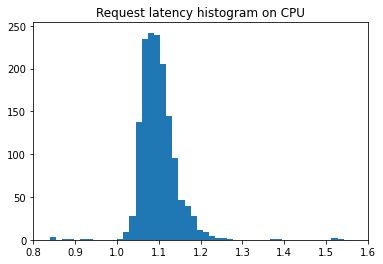

==== Default HuggingFace model on CPU benchmark ====

95 % of requests take less than 1172.8814244270325 ms
Rough request throughput/second is 4.54340184162512


In [18]:
# Display results 
from matplotlib.pyplot import hist, title, show, xlim
import numpy as np

TPS = (num_preds * num_threads) / end

t = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t, q=[50, 90, 95, 99])

hist(t, bins=100)
title("Request latency histogram on CPU")
xlim(0.8, 1.6)
show()

print("==== Default HuggingFace model on CPU benchmark ====\n")
print(f"95 % of requests take less than {latency_percentiles[2]*1000} ms")
print(f"Rough request throughput/second is {TPS}")

We can see that request latency is in the 1-1.2 second range, and throughput is ~4.5 TPS.

### Benchmark Inferentia based endpoint <a name="benchinf1"></a>

In [19]:
%%time
# Run benchmark 

import threading
import time
import boto3

num_preds = 300
num_threads = 5

times = []


def predict():
    thread_id = threading.get_ident()
    print(f"Thread {thread_id} started")

    for i in range(num_preds):
        tick = time.time()
        response = compiled_inf1_predictor.predict(payload)
        tock = time.time()
        times.append((thread_id, tock - tick))


threads = []
[threads.append(threading.Thread(target=predict, daemon=False)) for i in range(num_threads)]
[t.start() for t in threads]

# Make a rough estimate of total time, wait for threads
start = time.time()
[t.join() for t in threads]
end = time.time() - start

Thread 140625879480064 started
Thread 140625837516544 started
Thread 140625829123840 started
Thread 140625862694656 started
Thread 140625851594496 started
CPU times: user 2.97 s, sys: 152 ms, total: 3.12 s
Wall time: 9.48 s


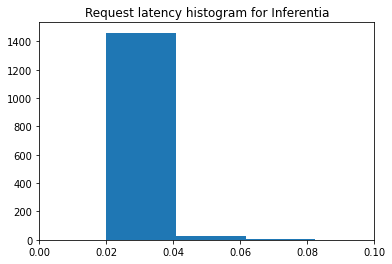

==== HuggingFace model compiled for Inferentia benchmark ====

95 % of requests take less than 36.40700578689575 ms
Rough request throughput/second is 158.36348549205135


In [20]:
# Display results

from matplotlib.pyplot import hist, title, show, savefig, xlim
import numpy as np

TPS = (num_preds * num_threads) / end

t = [duration for thread__id, duration in times]
latency_percentiles = np.percentile(t, q=[50, 90, 95, 99])

hist(t, bins=100)
title("Request latency histogram for Inferentia")
xlim(0, 0.1)
show()

print("==== HuggingFace model compiled for Inferentia benchmark ====\n")
print(f"95 % of requests take less than {latency_percentiles[2]*1000} ms")
print(f"Rough request throughput/second is {TPS}")

We can see that request latency is in the 0.02-0.05 millisecond range, and throughput is ~157 TPS.

---

# Conclusion <a name="conclusions"></a>

Using inf1 instances latency dropped to 25-30 millisecond range while throughput has increased to 220 TPS 

The increase in performance obtained from using inf1 instances, paired with the cost reduction and the use of known SageMaker SDK APIs, enables new benefits with little development effort and a gentle learning curve. 

---

# Clean up <a name="cleanup"></a>

In [21]:
normal_predictor.delete_model()
normal_predictor.delete_endpoint()
compiled_inf1_predictor.delete_model()
compiled_inf1_predictor.delete_endpoint()